#**01** Project Initialization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets
from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  MaxPool1D, SimpleRNN
import keras
nltk.download('wordnet')
from keras.regularizers import l2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function for plotting

In [3]:
def plotLearningCurve(history,epochs):
    
    epochRange = range(1,epochs+1)
    fig , ax = plt.subplots(1,2,figsize = (10,5))
  
    ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.show()

#**02** Preprocessing

## Load & process IMDB data

In [4]:
data=pd.read_csv('/content/drive/MyDrive/IMDBDataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Check if dataset is balanced

In [5]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Load stopwords and clean dataset

In [6]:
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought wonderful way spend time hot summer ...,positive
3,Basically there's family little boy (Jake) thi...,negative
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive


Perform lemmatization on the individual tokens in order to get the base words

In [7]:


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data.head()

,review,sentiment
0,One reviewer mentioned watching 1 Oz episode h...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought wonderful way spend time hot summer ...,positive
3,Basically there's family little boy (Jake) thi...,negative
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive


Convert the target variable to 0, 1

In [8]:

data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]
data.head()

,review,sentiment
0,One reviewer mentioned watching 1 Oz episode h...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically there's family little boy (Jake) thi...,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",1


Convert to lowercase

In [9]:
data['review'] = data['review'].apply(str.lower)
data.head() 

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought wonderful way spend time hot summer ...,1
3,basically there's family little boy (jake) thi...,0
4,"petter mattei's ""love time money"" visually stu...",1


Remove Breaks

In [10]:
data['review'] = data['review'].str.replace('<br />','')
data.head() 

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,1
1,a wonderful little production. the filming tec...,1
2,i thought wonderful way spend time hot summer ...,1
3,basically there's family little boy (jake) thi...,0
4,"petter mattei's ""love time money"" visually stu...",1


Check for URLs and remove them

In [11]:
def Find(string):
 
    # findall() has been used
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, string)
    return [x[0] for x in url]
Urls = []
for i, x in enumerate(data.review):
    Urls.append(Find(x)) 

print(Urls)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [12]:
data['review'] = data['review'].str.replace('http\S+|www.\S+', '', case=False)

<ipython-input-12-f3aee0d5f89e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('http\S+|www.\S+', '', case=False)


Remove punctuation

In [13]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['review'] = data['review'].apply(lambda x: remove_punct(x))
data.head(100)

,review,sentiment
0,one reviewer mentioned watching oz episode ho...,1
1,a wonderful little production the filming tech...,1
2,i thought wonderful way spend time hot summer ...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stunni...,1
...,...,...
95,daniel daylewis versatile actor alive english ...,1
96,my guess would originally going least two part...,0
97,well i like watch bad horror bmovies cause i t...,0
98,this is worst movie i ever seen well as worst ...,0


Copy dataset in order to use it in optimization phase with the basic preprocessing applied

In [14]:
IMDB_Opt_phase = data.copy()

Split data into train and test

In [15]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)

#train dataset
Xtrain, ytrain = train['review'], train['sentiment']

#test dataset
Xtest, ytest = test['review'], test['sentiment']

print(Xtrain.shape,ytrain.shape)
print(Xtest.shape,ytest.shape)

(40000,) (40000,)
(10000,) (10000,)


Create vectors for speeding up the process so as instead of operating on a single value at a time to operating on a set of values (vector) at one time

In [16]:
#vect = TfidfVectorizer()
#Xtrain_vect= vect.fit_transform(Xtrain)
#Xtest_vect = vect.transform(Xtest)


#count_vect = CountVectorizer() 
#Xtrain_count = count_vect.fit_transform(Xtrain)
#Xtest_count = count_vect.transform(Xtest)

Create tokens from training dataset by converting the sentence into list of words

In [17]:
#Break the sentence into words
MAX_VOCAB_SIZE = 10000 # will be used as parameter for embeding layer in lstm
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  185218


Create sequences of reviews

In [18]:
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

Allow choice on max length of sequences

In [19]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1503


In [20]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

Maximum length of the sequence when considering data only two standard deviations from average: 323
The above calculated number coveres approximately 94.49 % of data


Split training set in order to create validation set and perform padding in order to standardise the length of all thse different reviews

In [21]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [22]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

## Load Twitter data for test

In [23]:
Twitterdata=pd.read_csv('/content/drive/MyDrive/train_tweet.csv')
Twitterdata.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Drop column ID

In [24]:
Twitterdata.drop('id', inplace=True, axis=1)
Twitterdata.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


Rename collumns

In [25]:
Twitterdata.rename(columns = {'label':'sentiment'}, inplace = True)
Twitterdata.head()

,sentiment,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


Check if dataset is balanced just for informative reasson since its just for test

In [26]:
Twitterdata['sentiment'].value_counts()

0    29720
1     2242
Name: sentiment, dtype: int64

In the following code we will apply the same preprocessing steps on Twiiter dataset

In [27]:
#Load stopwords and clean dataset
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
Twitterdata['tweet'] = Twitterdata['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


#Perform lemmatization on the individual tokens in order to get the base words

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
Twitterdata['tweet'] = Twitterdata.tweet.apply(lemmatize_text)


#Convert to lowercase
Twitterdata['tweet'] = Twitterdata['tweet'].apply(str.lower)
data.head() 

#Remove Breaks
Twitterdata['tweet'] = Twitterdata['tweet'].str.replace('<br />','')


#Check for URLs and remove them
def Find(string):
    # findall() has been used
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, string)
    return [x[0] for x in url]
Urls = []
for i, x in enumerate(data.review):
    Urls.append(Find(x)) 

Twitterdata['tweet'] = Twitterdata['tweet'].str.replace('http\S+|www.\S+', '', case=False)


#Remove punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['review'] = data['review'].apply(lambda x: remove_punct(x))


Twitterdata.head() 

<ipython-input-27-f1e753a30c95>:38: FutureWarning: The default value of regex will change from True to False in a future version.
  Twitterdata['tweet'] = Twitterdata['tweet'].str.replace('http\S+|www.\S+', '', case=False)


,sentiment,tweet
0,0,@user father dysfunctional selfish drag kid dy...
1,0,@user @user thanks #lyft credit can't use caus...
2,0,bihday majesty
3,0,#model love u take u time urð±!!! ððð...
4,0,factsguide: society #motivation


Additionally we remove the @user as its a common observation it in twitter data

In [28]:
# removing usernames from tweet
Twitterdata['tweet']= Twitterdata.tweet.str.replace('@user', '')
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode ho...,1
1,a wonderful little production the filming tech...,1
2,i thought wonderful way spend time hot summer ...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stunni...,1


Finaly we initialize Xtest and ytest variables

In [29]:
#test dataset
XtestTw, ytestTw = Twitterdata['tweet'], Twitterdata['sentiment']

print(XtestTw.shape,ytestTw.shape)

(31962,) (31962,)


Create sequences of reviews and perform padding

In [30]:
#Create sequences
seq_testTw =  tokenizer.texts_to_sequences(XtestTw)


#Pad the sequence
#choice of maximum length of sequences
seq_len_listTw = [len(i) for i in seq_testTw]

#if we take the direct maximum then
max_lenTw = max(seq_len_listTw)
print('Maximum length of sequence in the list: {}'.format(max_lenTw))

# when setting the maximum length of sequence, variability around the average is used.
max_seq_lenTw = np.mean(seq_len_listTw) + 2 * np.std(seq_len_listTw)
max_seq_lenTw = int(max_seq_lenTw)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_lenTw))

pad_testTw=pad_sequences(seq_testTw,truncating = 'post', padding = 'pre',maxlen=323)  #

Maximum length of sequence in the list: 42
Maximum length of the sequence when considering data only two standard deviations from average: 15


#**03** Model

### CNN LSTM

Create the model

In [30]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

Train the model

In [31]:
D = 64 #embedding dims
epochs = 4

In [32]:

r_1,model_1,n_epochs_1 = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 323)]             0         
                                                                 
 embedding (Embedding)       (None, 323, 64)           11854016  
                                                                 
 batch_normalization (BatchN  (None, 323, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 323, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 319, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 319, 32)           0         
                                  

Ploting the results

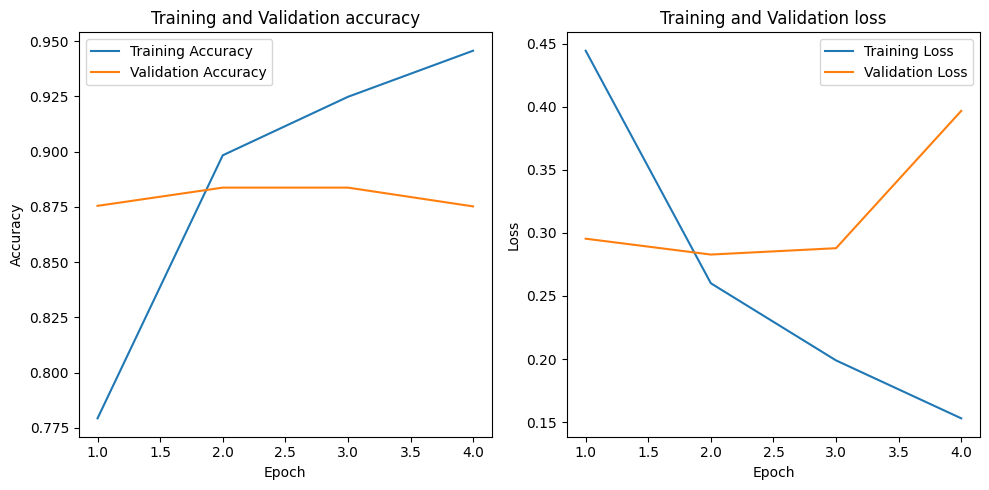

In [33]:
plotLearningCurve(r_1,n_epochs_1)    

Evaluate model with test

In [34]:
score_cnn_lstm, acc_cnn_lstm = model_1.evaluate(pad_test, ytest)

313/313 [==============================] - 4s 10ms/step - loss: 0.3769 - accuracy: 0.8798


## LSTM

In [36]:
# model initialization
model_2 = keras.Sequential([
    keras.layers.Embedding(MAX_VOCAB_SIZE, D , input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 323, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 709,169
Trainable params: 709,169
Non-trainable params: 0
_________________________________________________________________


Model Training and Evaluation

In [37]:
num_epochs = 5
LSTM_res = model_2.fit(Xtrain, ytrain, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
900/900 [==============================] - 149s 161ms/step - loss: 0.3850 - accuracy: 0.8243 - val_loss: 0.2997 - val_accuracy: 0.8822
Epoch 2/5
900/900 [==============================] - 53s 59ms/step - loss: 0.2323 - accuracy: 0.9094 - val_loss: 0.3084 - val_accuracy: 0.8694
Epoch 3/5
900/900 [==============================] - 36s 40ms/step - loss: 0.1734 - accuracy: 0.9344 - val_loss: 0.3232 - val_accuracy: 0.8766
Epoch 4/5
900/900 [==============================] - 31s 34ms/step - loss: 0.1343 - accuracy: 0.9506 - val_loss: 0.3547 - val_accuracy: 0.8731
Epoch 5/5
900/900 [==============================] - 31s 34ms/step - loss: 0.0894 - accuracy: 0.9709 - val_loss: 0.4097 - val_accuracy: 0.8600


Ploting the results

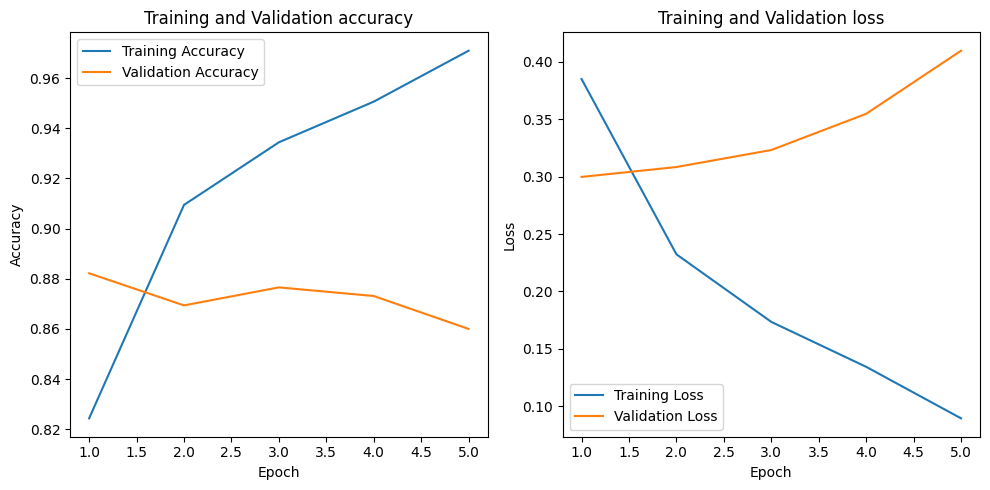

In [38]:
def plotLearningCurve(history,epochs):
    
    epochRange = range(1,epochs+1)
    fig , ax = plt.subplots(1,2,figsize = (10,5))
  
    ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.show()

plotLearningCurve(LSTM_res,num_epochs)    

Evaluate model with test

In [39]:
score_lstm, acc_lstm = model_2.evaluate(pad_test, ytest)

313/313 [==============================] - 5s 15ms/step - loss: 0.4108 - accuracy: 0.8593


## CNN

In [41]:
model_4 = Sequential()
model_4.add(Embedding(MAX_VOCAB_SIZE,D, input_length=max_seq_len))
model_4.add(Conv1D(256, 3, activation='relu', padding='same'))  #MP First layer
model_4.add(MaxPool1D(2, padding='same'))
model_4.add(Dropout(0.2))
model_4.add(Conv1D(128, 3, activation='relu', padding='same')) #MP second Layer
model_4.add(MaxPool1D(2, padding='same'))
model_4.add(Dropout(0.2))
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 323, 64)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 323, 256)          49408     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 162, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 162, 128)          98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 81, 128)          0         
 1D)                                                  

In [42]:
CNN_res = model_4.fit(Xtrain, ytrain, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
900/900 [==============================] - 91s 99ms/step - loss: 0.4256 - accuracy: 0.7682 - val_loss: 0.2708 - val_accuracy: 0.8828
Epoch 2/5
900/900 [==============================] - 32s 35ms/step - loss: 0.2192 - accuracy: 0.9133 - val_loss: 0.2613 - val_accuracy: 0.8922
Epoch 3/5
900/900 [==============================] - 18s 20ms/step - loss: 0.1469 - accuracy: 0.9433 - val_loss: 0.2908 - val_accuracy: 0.8803
Epoch 4/5
900/900 [==============================] - 15s 16ms/step - loss: 0.0901 - accuracy: 0.9669 - val_loss: 0.3808 - val_accuracy: 0.8750
Epoch 5/5
900/900 [==============================] - 18s 20ms/step - loss: 0.0576 - accuracy: 0.9794 - val_loss: 0.4654 - val_accuracy: 0.8813


Plotting the results

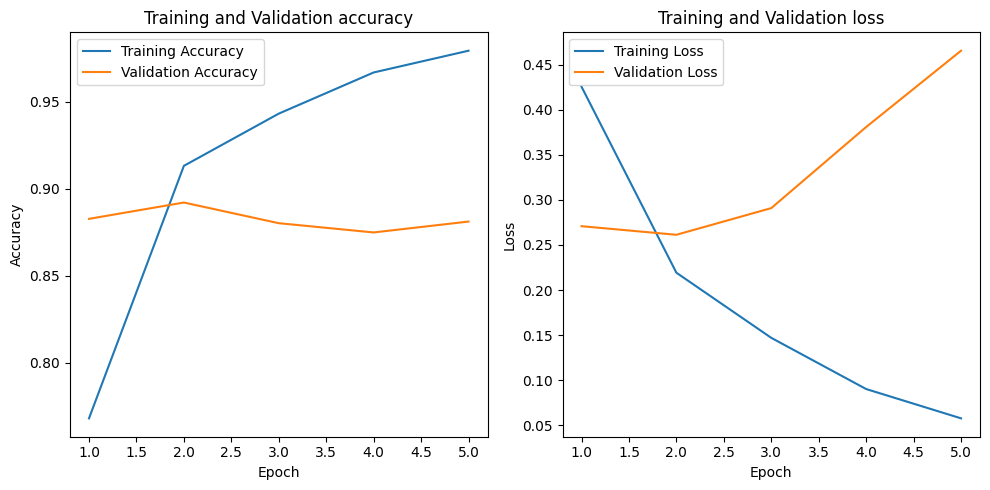

In [43]:
plotLearningCurve(CNN_res,num_epochs)    

Evaluate the model with test

In [44]:
score_cnn, acc_cnn = model_4.evaluate(pad_test, ytest)

313/313 [==============================] - 2s 6ms/step - loss: 0.4961 - accuracy: 0.8745


## Evaluation on Twitter dataset

CNN-LSTM on Twitter dataset

In [45]:
#Evaluate models of 5 epoch
loss, accuracy = model_1.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 11s 11ms/step - loss: 1.0542 - accuracy: 0.5435


LSTM on Twitter dataset

In [47]:
loss_lstm, accuracy_lstm = model_2.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 13s 13ms/step - loss: 1.3942 - accuracy: 0.4562


CNN on Twitter dataset

In [48]:
loss_cnn, accuracy_cnn = model_4.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 5s 5ms/step - loss: 1.3856 - accuracy: 0.4294


#**04** Optimization for accuracy on IMDB dataset

In optimization phase we decided to iuse the Word2Vec model and observe any improvement in accuracy

##Word2Vec

In [105]:
from gensim.models import Word2Vec

In [106]:
#Split data into train and test
train_w2v, test_w2v= train_test_split(IMDB_Opt_phase, test_size=0.2, random_state=42)

#train dataset
Xtrain_w2v, ytrain_w2v = train_w2v['review'], train_w2v['sentiment']

#test dataset
Xtest_w2v, ytest_w2v = test_w2v['review'], test_w2v['sentiment']

print(Xtrain_w2v.shape,ytrain_w2v.shape)
print(Xtest_w2v.shape,ytest_w2v.shape)

######################

D = 64 #embedding dims

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), Xtrain_w2v))

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=D,  #D = 64 #embedding dims
                 workers=8,
                 min_count=5)
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))


#Tokenizer
vocab_length = 60000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain_w2v)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)



#Creating embeding
embedding_matrix = np.zeros((vocab_length, D ))  # D = 64 #embedding dims

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)


######################


Xtrain_w2v = pad_sequences(tokenizer.texts_to_sequences(Xtrain_w2v), maxlen=max_seq_len)
Xtest_w2v  = pad_sequences(tokenizer.texts_to_sequences(Xtest_w2v) , maxlen=max_seq_len)

print("X_train_padW2v.shape:", Xtrain_w2v.shape)
print("X_test_padW2v.shape :", Xtest_w2v.shape)

(40000,) (40000,)
(10000,) (10000,)
Vocabulary Length: 37882
Tokenizer vocab length: 60000
Embedding Matrix Shape: (60000, 64)
X_train_padW2v.shape: (40000, 323)
X_test_padW2v.shape : (10000, 323)


##LSTM Word2Vec

###IMDB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 323, 64)           3840000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,909,169
Trainable params: 3,909,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1125/1125 [==============================] - 154s 132ms/step - loss: 0.4987 - accuracy: 0.7340 - val_l

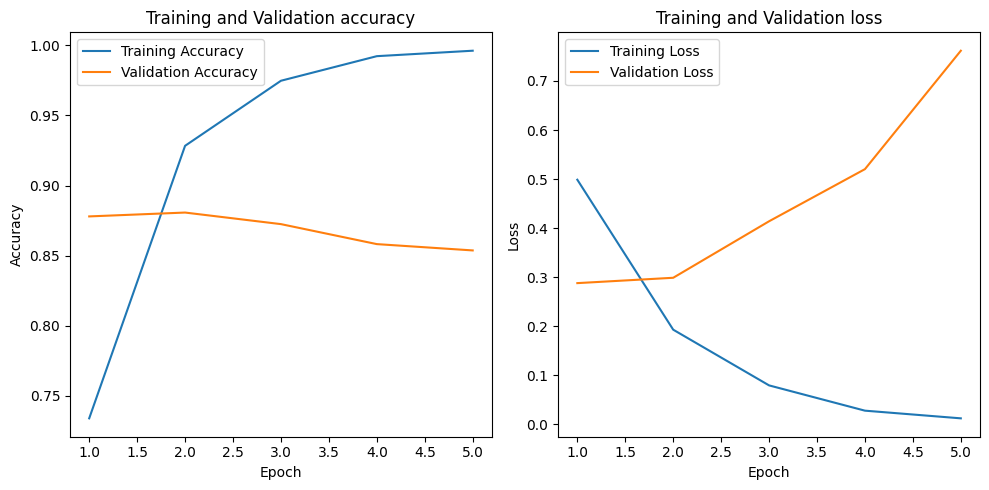

313/313 [==============================] - 5s 14ms/step - loss: 0.7187 - accuracy: 0.8554


In [40]:
# model initialization
model_2_w2v = keras.Sequential([
    keras.layers.Embedding(vocab_length, D ,weights=[embedding_matrix], input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2_w2v.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2_w2v.summary()

#Train model
num_epochs = 5
LSTM_res_w2v = model_2_w2v.fit(Xtrain_w2v, ytrain_w2v, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(LSTM_res_w2v,num_epochs)   

#Evaluate
score_lstm_w2v, acc_lstm_w2v = model_2_w2v.evaluate(pad_test, ytest)

### Evaluation on Twitter dataset

In [42]:
loss_lstm_w2v, accuracy_lstm_w2v = model_2_w2v.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 2.0182 - accuracy: 0.4610


##CNN Word2Vec

###IMDB

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 323, 64)           3840000   
                                                                 
 conv1d_2 (Conv1D)           (None, 323, 256)          49408     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 162, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 162, 128)          98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 81, 128)          0         
 1D)                                                  

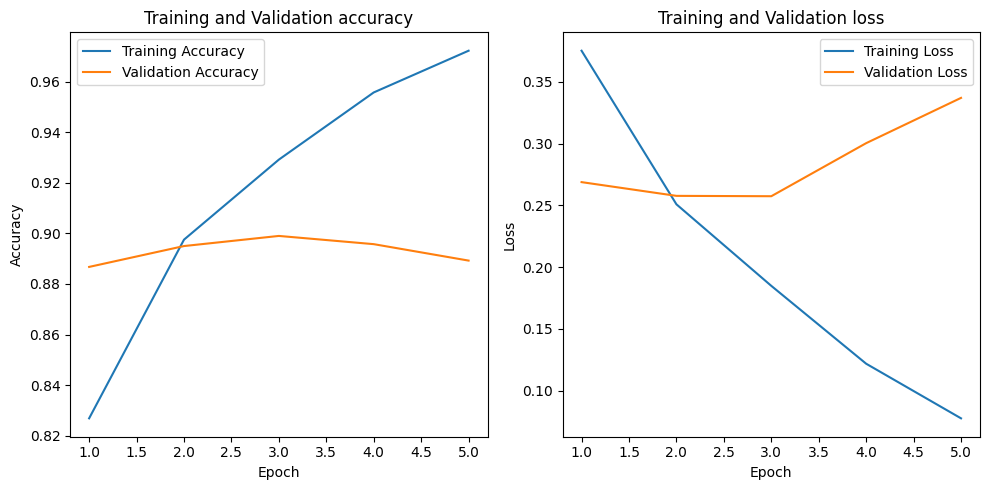

313/313 [==============================] - 1s 4ms/step - loss: 0.3366 - accuracy: 0.8883


In [107]:
#Create model
model_4_w2v = Sequential()
model_4_w2v.add(Embedding(vocab_length, D ,weights=[embedding_matrix], input_length=max_seq_len))
model_4_w2v.add(Conv1D(256, 3, activation='relu', padding='same'))  #MP First layer
model_4_w2v.add(MaxPool1D(2, padding='same'))
model_4_w2v.add(Dropout(0.2))
model_4_w2v.add(Conv1D(128, 3, activation='relu', padding='same')) #MP second Layer
model_4_w2v.add(MaxPool1D(2, padding='same'))
model_4_w2v.add(Dropout(0.2))
model_4_w2v.add(Flatten())
model_4_w2v.add(Dense(128, activation='relu'))

model_4_w2v.add(Dense(1, activation='sigmoid'))
model_4_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4_w2v.summary()


#Train
CNN_res_w2v = model_4_w2v.fit(Xtrain_w2v, ytrain_w2v, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(CNN_res_w2v,num_epochs)  


#Evaluate
score_cnn_w2v, acc_cnn_w2v = model_4_w2v.evaluate(pad_test, ytest)

### Evaluation on Twitter dataset

In [108]:
loss_cnn_w2v, accuracy_cnn_w2v = model_4_w2v.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 4s 4ms/step - loss: 1.2549 - accuracy: 0.4117


##CNN-LSTM Word2Vec

###IMDB

In [109]:
print("----Building the model----")
i = Input(shape=(max_seq_len,))
x = Embedding(vocab_length, D ,weights=[embedding_matrix], input_length = max_seq_len)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(32,5,activation = 'relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_1_w2v = Model(i, x)
model_1_w2v.summary()

#Training the LSTM
print("----Training the network----")
model_1_w2v.compile(optimizer= Adam(0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy'])

num_epochs = 5
#Train
CNN_LSTM_res_w2v = model_1_w2v.fit(Xtrain_w2v, ytrain_w2v, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)





----Building the model----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 323)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 323, 64)           3840000   
                                                                 
 batch_normalization_2 (Batc  (None, 323, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 323, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 319, 32)           10272     
                                                                 
 dropout_9 (Dropout)         (None, 319, 32)           0         
                                

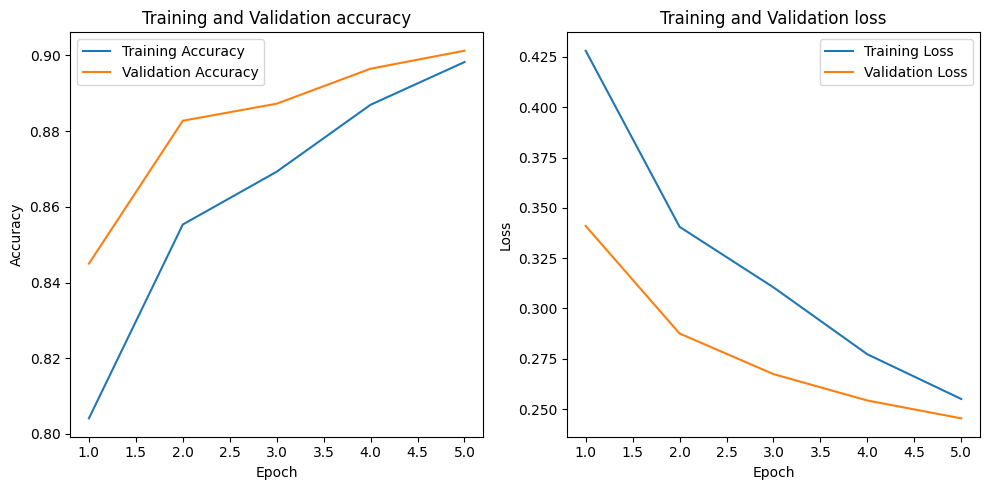

313/313 [==============================] - 4s 10ms/step - loss: 0.2635 - accuracy: 0.8908


In [110]:
#Plot
plotLearningCurve(CNN_LSTM_res_w2v,num_epochs)  


#Evaluate
score_cnn_lstm_w2v, acc_cnn_lstm_w2v = model_1_w2v.evaluate(pad_test, ytest)

### Evaluation on Twitter dataset

In [111]:
loss_w2v, accuracy_w2v = model_1_w2v.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.2266 - accuracy: 0.2534


#**05** Optimization for overfiting

##CNN-LSTM

###Decrease epoch

We see that in 4 epochs we have overfiting while accuracy is not increasing while loss has already starting increasing from epoch 3. Thus we will rerun the model for 3 epochs.

----Building the model----
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 323)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 323, 64)           11854016  
                                                                 
 batch_normalization_1 (Batc  (None, 323, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 323, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 319, 32)           10272     
                                                                 
 dropout_4 (Dropout)         (None, 319, 32)           0         
                                

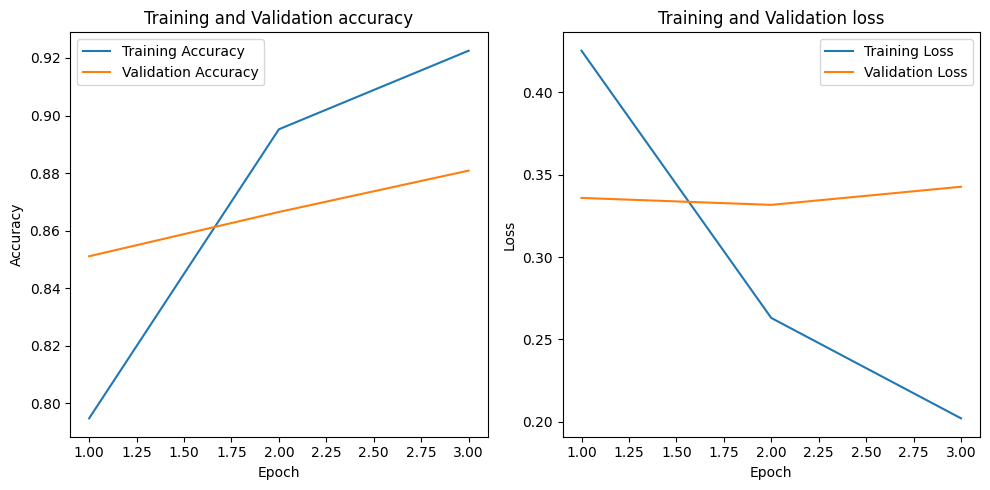

313/313 [==============================] - 3s 10ms/step - loss: 0.3769 - accuracy: 0.8798


In [ ]:
#Train the model
r_1_opt,model_1_opt,n_epochs_1_opt = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,3)

#plot results
plotLearningCurve(r_1_opt,n_epochs_1_opt)   

#Evaluate
score_cnn_lstm, acc_cnn_lstm = model_1.evaluate(pad_test, ytest)

In [ ]:
#Evaluate models of 3 epoch in Twitter dataset
loss, accuracy = model_1_opt.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 16s 14ms/step - loss: 0.8658 - accuracy: 0.5959


###Decrease complexity

----Building the model----
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 323)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 323, 64)           11854016  
                                                                 
 batch_normalization_3 (Batc  (None, 323, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 323, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 319, 32)           10272     
                                                                 
 dropout_12 (Dropout)        (None, 319, 32)           0         
                                

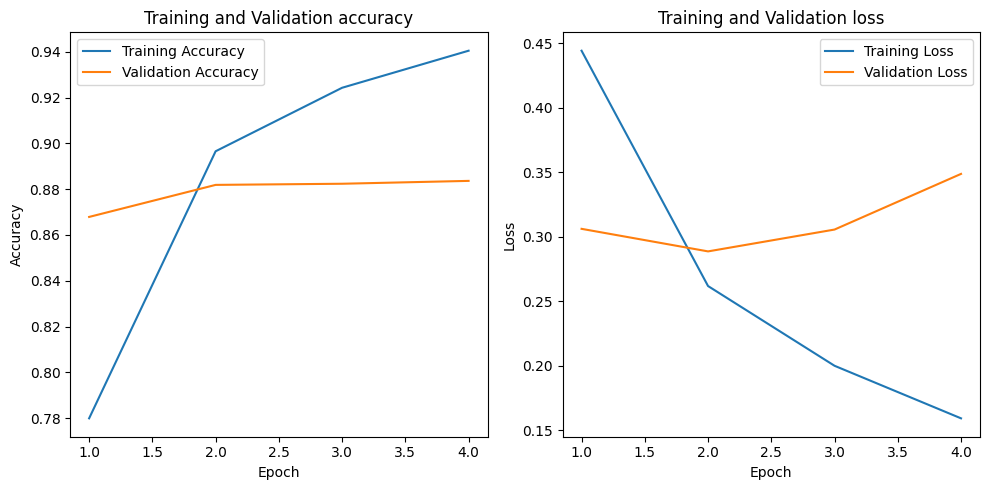

313/313 [==============================] - 4s 9ms/step - loss: 0.3406 - accuracy: 0.8823


In [112]:
#Create model with 50 units instead of 64
def lstm_model_dc(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

# Train model
D = 64 #embedding dims
epochs = 4
r_1_dc,model_1_dc,n_epochs_1_dc = lstm_model_dc(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)


#Plotting
plotLearningCurve(r_1_dc,n_epochs_1_dc)    

#Evaluate model with test
score_cnn_lstm_dc, acc_cnn_lstm_dc = model_1_dc.evaluate(pad_test, ytest)

In [113]:
loss_cnn_lstm_dc, accuracy_cnn_lstm_dc = model_1_dc.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.1628 - accuracy: 0.4258


###Regularization L2

----Building the model----
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 323)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 323, 64)           11854016  
                                                                 
 batch_normalization_4 (Batc  (None, 323, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 323, 64)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 319, 32)           10272     
                                                                 
 dropout_15 (Dropout)        (None, 319, 32)           0         
                                

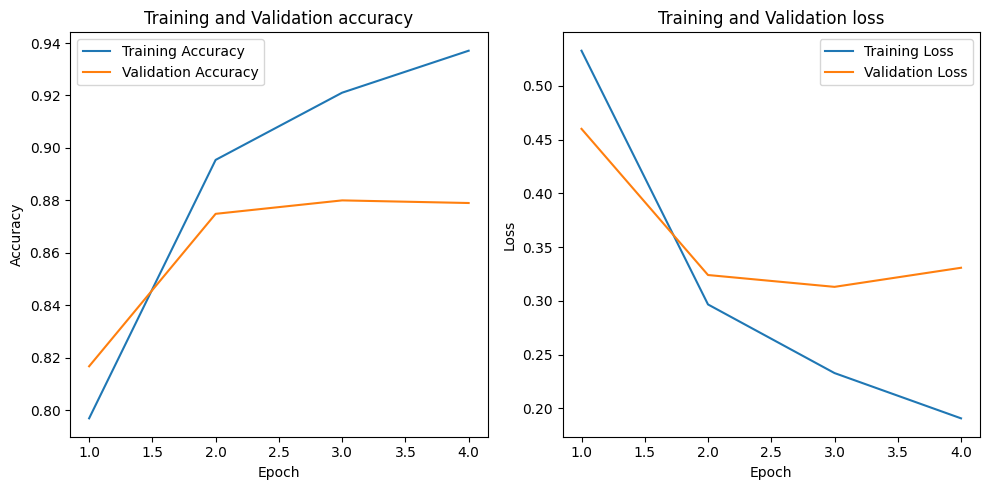

313/313 [==============================] - 4s 10ms/step - loss: 0.3139 - accuracy: 0.8790


In [114]:
#Create model with 50 units instead of 64
def lstm_model_reg(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

# Train model
D = 64 #embedding dims
epochs = 4
r_1_reg,model_1_reg,n_epochs_1_reg= lstm_model_reg(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)


#Plotting
plotLearningCurve(r_1_reg,n_epochs_1_reg)    

#Evaluate model with test
score_cnn_lstm_reg, acc_cnn_lstm_reg = model_1_reg.evaluate(pad_test, ytest)

In [115]:
loss_cnn_lstm_reg, accuracy_cnn_lstm_reg = model_1_reg.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.0616 - accuracy: 0.3529


##LSTM

###Decrease epoch

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 323, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 709,169
Trainable params: 709,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
900/900 [==============================] - 142s 147ms/step - loss: 0.3810 - accuracy: 0.8277 - val_loss: 0

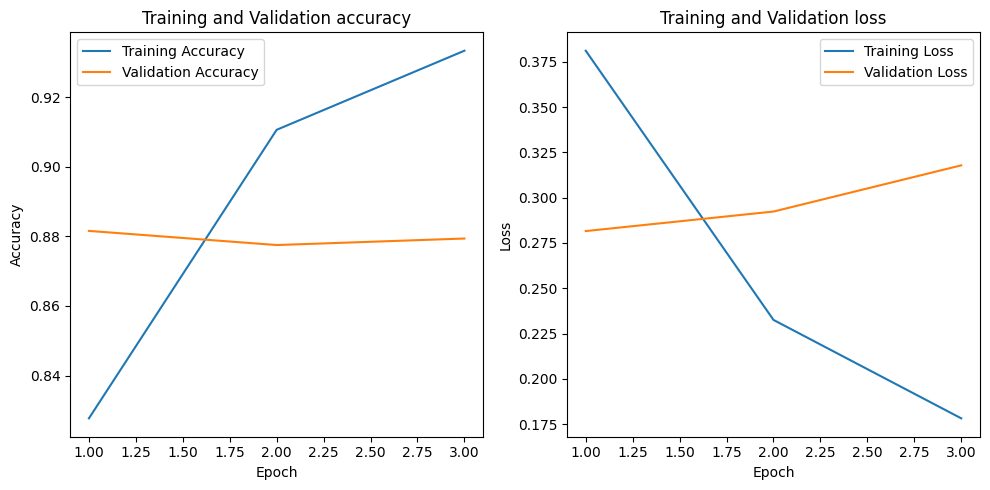

313/313 [==============================] - 4s 10ms/step - loss: 0.3228 - accuracy: 0.8716


In [33]:
D = 64 #embedding dims
#epochs = 4

# model initialization
model_2_opt = keras.Sequential([
    keras.layers.Embedding(MAX_VOCAB_SIZE, D , input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2_opt.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2_opt.summary()


#Train model for 7 epochs
LSTM_res_opt = model_2_opt.fit(Xtrain, ytrain, 
                    epochs=3, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(LSTM_res_opt,3)    


#Evaluate
score_lstm_opt, acc_lstm_opt = model_2_opt.evaluate(pad_test, ytest)



Twitter

In [34]:
loss_lstm, accuracy_lstm = model_2_opt.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.0680 - accuracy: 0.3750


###Decrease complexity

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 323, 64)           640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              46000     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                2424      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 688,449
Trainable params: 688,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
900/900 [==============================] - 106s 114ms/step - loss: 0.3878 - accuracy: 0.8232 - val_loss:

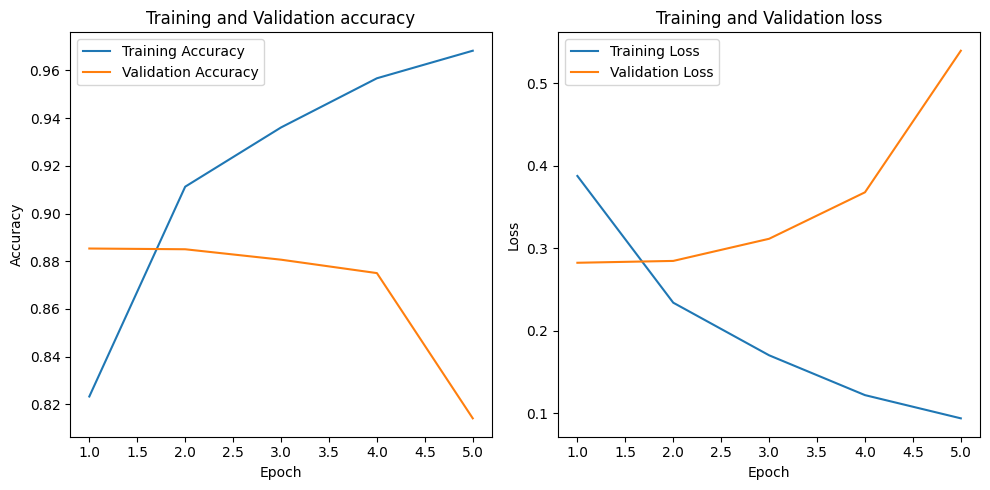

313/313 [==============================] - 4s 10ms/step - loss: 0.5533 - accuracy: 0.8009


In [35]:
# model initialization
model_2_opt_dc = keras.Sequential([
    keras.layers.Embedding(MAX_VOCAB_SIZE, D , input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(50)),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2_opt_dc.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2_opt_dc.summary()


#Train model for 7 epochs
LSTM_res_opt_dc = model_2_opt_dc.fit(Xtrain, ytrain, 
                    epochs=5, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(LSTM_res_opt_dc,5)    


#Evaluate
score_lstm_opt_dc, acc_lstm_opt_dc = model_2_opt_dc.evaluate(pad_test, ytest)



Twitter

In [36]:
loss_lstm_dc, accuracy_lstm_dc = model_2_opt_dc.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.2475 - accuracy: 0.4820


###Regularization L2

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 323, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 709,169
Trainable params: 709,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
900/900 [==============================] - 100s 107ms/step - loss: 0.5489 - accuracy: 0.7831 - val_loss:

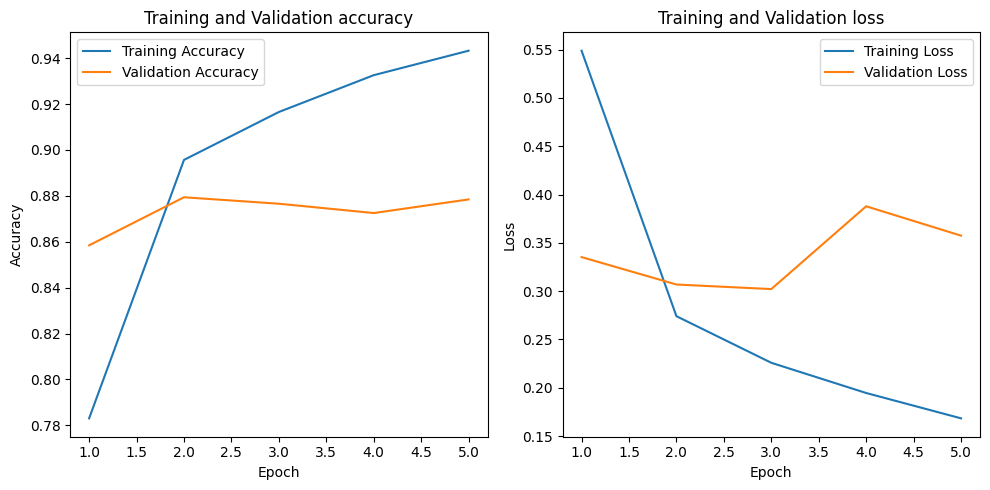

313/313 [==============================] - 5s 12ms/step - loss: 0.3745 - accuracy: 0.8731


In [37]:
# model initialization
model_2_opt_reg = keras.Sequential([
    keras.layers.Embedding(MAX_VOCAB_SIZE, D , input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(64, kernel_regularizer=l2(0.01))),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2_opt_reg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2_opt_reg.summary()


#Train model for 7 epochs
LSTM_res_opt_reg = model_2_opt_reg.fit(Xtrain, ytrain, 
                    epochs=5, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(LSTM_res_opt_reg,5)    


#Evaluate
score_lstm_opt_reg, acc_lstm_opt_reg = model_2_opt_reg.evaluate(pad_test, ytest)



Twitter

In [38]:
loss_lstm_reg, accuracy_lstm_reg = model_2_opt_reg.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 0.9217 - accuracy: 0.4930


###Dropout layer

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 323, 64)           640000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 24)                3096      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 709,169
Trainable params: 709,169
Non-trainable params: 0
________________________________________________

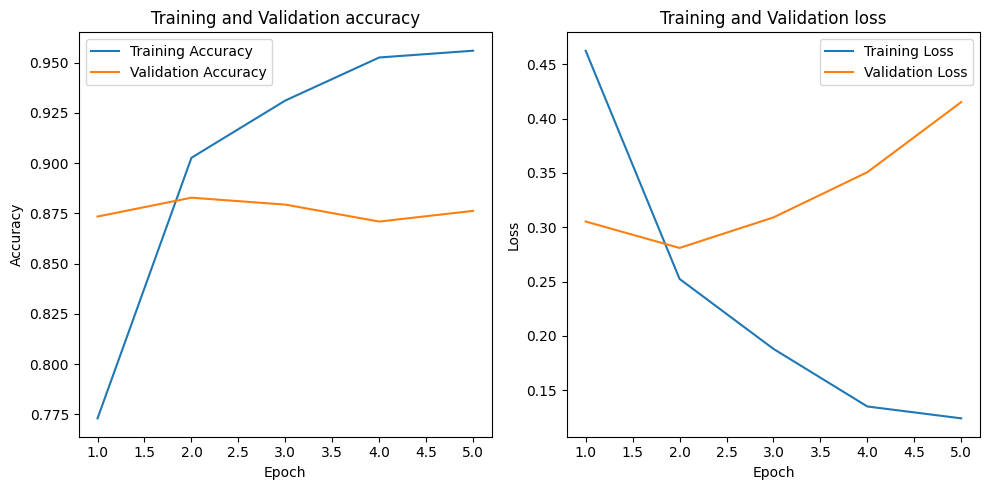

313/313 [==============================] - 5s 14ms/step - loss: 0.4419 - accuracy: 0.8695


In [39]:
# model initialization
model_2_opt_do = keras.Sequential([
    keras.layers.Embedding(MAX_VOCAB_SIZE, D , input_length=max_seq_len),  # where D is embedding_dim
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model_2_opt_do.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_2_opt_do.summary()


#Train model for 7 epochs
LSTM_res_opt_do = model_2_opt_do.fit(Xtrain, ytrain, 
                    epochs=5, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(LSTM_res_opt_do,5)    


#Evaluate
score_lstm_opt_do, acc_lstm_opt_do = model_2_opt_do.evaluate(pad_test, ytest)



Twitter

In [40]:
loss_lstm_do, accuracy_lstm_do = model_2_opt_do.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 10s 10ms/step - loss: 1.2417 - accuracy: 0.4548


##CNN

###Decrease epoch

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 323, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 323, 256)          49408     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 162, 256)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 162, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 128)          98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 81, 128)          0         
 1D)                                                  

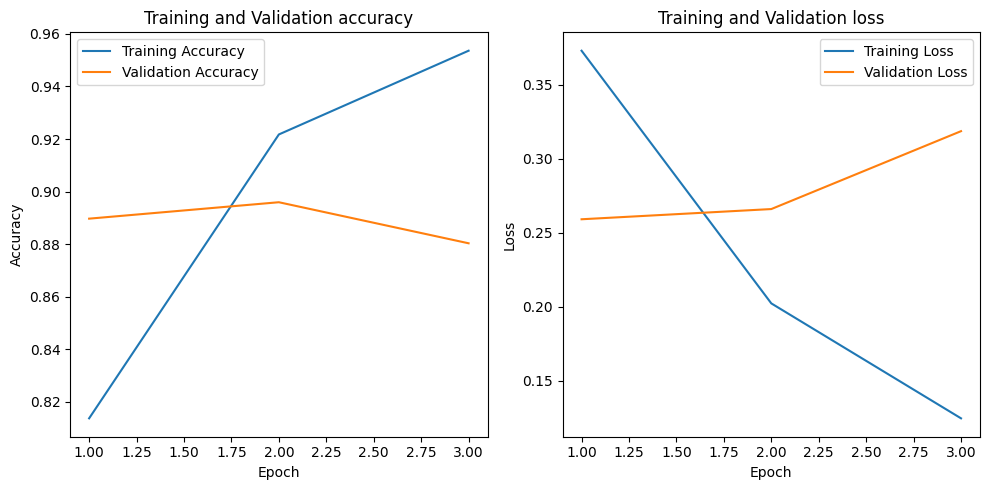

313/313 [==============================] - 2s 4ms/step - loss: 0.3185 - accuracy: 0.8795


In [41]:
#model

model_4_de = Sequential()
model_4_de.add(Embedding(MAX_VOCAB_SIZE,D, input_length=max_seq_len))
model_4_de.add(Conv1D(256, 3, activation='relu', padding='same'))  #MP First layer
model_4_de.add(MaxPool1D(2, padding='same'))
model_4_de.add(Dropout(0.2))
model_4_de.add(Conv1D(128, 3, activation='relu', padding='same')) #MP second Layer
model_4_de.add(MaxPool1D(2, padding='same'))
model_4_de.add(Dropout(0.2))
model_4_de.add(Flatten())
model_4_de.add(Dense(128, activation='relu'))

model_4_de.add(Dense(1, activation='sigmoid'))
model_4_de.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4_de.summary()


CNN_res_de = model_4_de.fit(Xtrain, ytrain, 
                    epochs=3, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(CNN_res_de,3)    

#Evaluate
score_cnn_de, acc_cnn_de = model_4_de.evaluate(pad_test, ytest)      

Twitter

In [42]:
loss_cnn_de, accuracy_cnn_de = model_4_de.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 4s 4ms/step - loss: 0.9524 - accuracy: 0.4242


###Decrease complexity

Remove the 2nd convolutional layer

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 323, 64)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 323, 256)          49408     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 162, 256)          0         
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               5308544   
                                                      

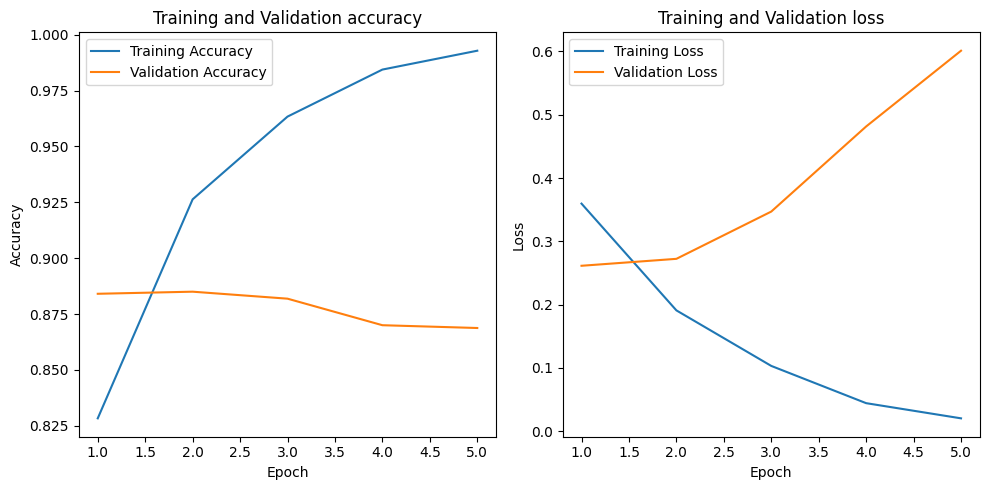

313/313 [==============================] - 1s 3ms/step - loss: 0.6460 - accuracy: 0.8706


In [43]:
#model

model_4_dc = Sequential()
model_4_dc.add(Embedding(MAX_VOCAB_SIZE,D, input_length=max_seq_len))
model_4_dc.add(Conv1D(256, 3, activation='relu', padding='same'))  #MP First layer
model_4_dc.add(MaxPool1D(2, padding='same'))
model_4_dc.add(Dropout(0.2))
#model_4_dc.add(Conv1D(128, 3, activation='relu', padding='same')) #MP second Layer
#model_4_dc.add(MaxPool1D(2, padding='same'))
#model_4_dc.add(Dropout(0.2))
model_4_dc.add(Flatten())
model_4_dc.add(Dense(128, activation='relu'))

model_4_dc.add(Dense(1, activation='sigmoid'))
model_4_dc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4_dc.summary()


CNN_res_dc = model_4_dc.fit(Xtrain, ytrain, 
                    epochs=5, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(CNN_res_dc,5)    

#Evaluate
score_cnn_dc, acc_cnn_dc = model_4_dc.evaluate(pad_test, ytest)    

Twitter

In [44]:
loss_cnn_dc, accuracy_cnn_dc = model_4_dc.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 3s 3ms/step - loss: 1.3659 - accuracy: 0.4340


###Regularization L2

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 323, 64)           640000    
                                                                 
 conv1d_3 (Conv1D)           (None, 323, 256)          49408     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 162, 256)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 162, 128)          98432     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 128)          0         
 1D)                                                  

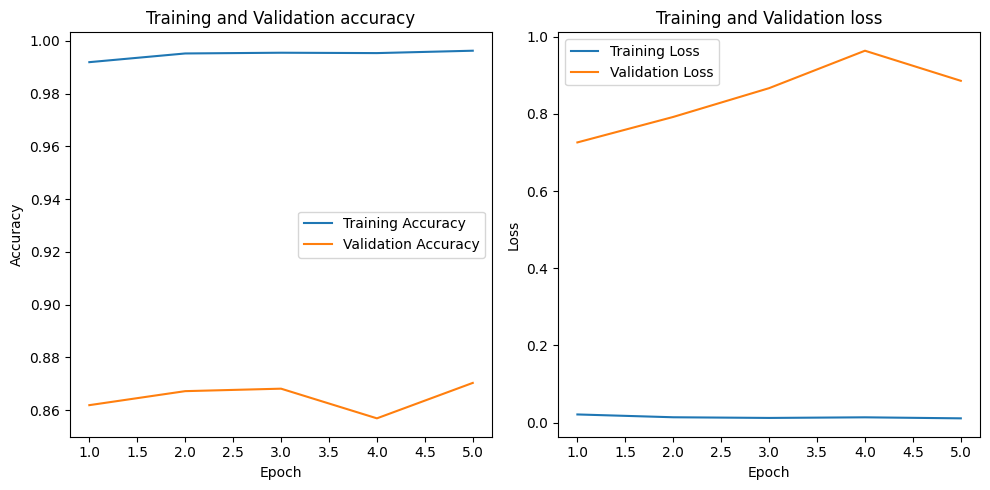

313/313 [==============================] - 2s 5ms/step - loss: 3.4208 - accuracy: 0.5036


In [45]:
#model

model_4_reg = Sequential()
model_4_reg.add(Embedding(MAX_VOCAB_SIZE,D, input_length=max_seq_len))
model_4_reg.add(Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01)))  #MP First layer
model_4_reg.add(MaxPool1D(2, padding='same'))
model_4_reg.add(Dropout(0.2))
model_4_reg.add(Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))) #MP second Layer
model_4_reg.add(MaxPool1D(2, padding='same'))
model_4_reg.add(Dropout(0.2))
model_4_reg.add(Flatten())
model_4_reg.add(Dense(128, activation='relu'))

model_4_reg.add(Dense(1, activation='sigmoid'))
model_4_reg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4_reg.summary()


CNN_res_reg = model_4_dc.fit(Xtrain, ytrain, 
                    epochs=5, verbose=1, 
                    validation_split=0.1)


#Plot
plotLearningCurve(CNN_res_reg,5)    

#Evaluate
score_cnn_reg, acc_cnn_reg = model_4_reg.evaluate(pad_test, ytest)       

Twitter

In [46]:
loss_cnn_reg, accuracy_cnn_reg = model_4_reg.evaluate(pad_testTw, ytestTw, verbose=1)

999/999 [==============================] - 4s 4ms/step - loss: 3.4283 - accuracy: 0.0701


#**06** Results

Results indicate that using CNN-LSTM had the best accuracy as it reached 0.8908 when using Word2Vec on IMDB dataset and 0.5935 when epochs decreased while evaluating on Twitter dataset.

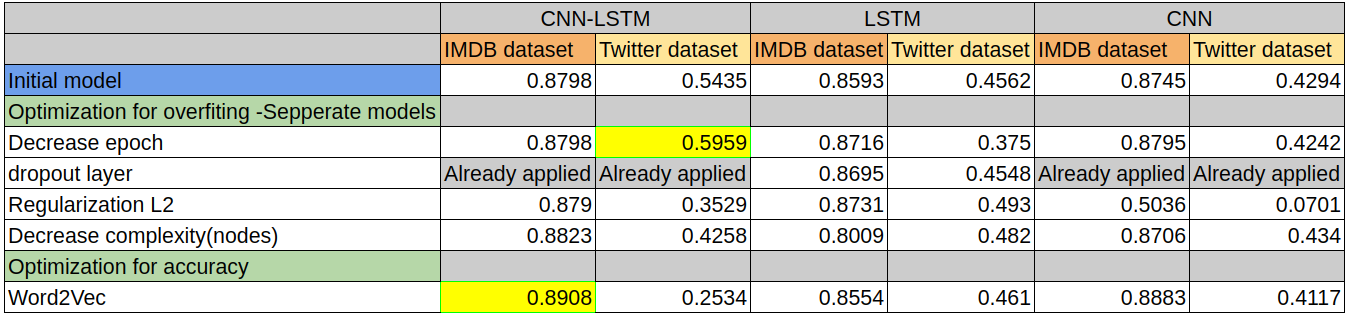